In [21]:
from datetime import date
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
df = pd.read_csv("../Resources/btcjoin.csv", parse_dates=['date'])
btc_df = yf.Ticker('BTC-USD').history(period='7y',interval='1d',actions=False).reset_index()
btc_df = btc_df.loc[(btc_df['Date'] > '2022-10-25')]
btc_df['Close']=btc_df['Close'].astype("float")
df['price']=df['price'].str.replace(',','')
df['price']=df['price'].astype("float")
btc_df = btc_df.rename(columns={"Close": "price", "Date":"date"})
df = pd.merge(df, btc_df, on=['date', 'price'], how='outer')
df = df.rename(columns={"value": "wallets"})
df = df.drop(columns=['volume','change', 'low', 'high', 'open','Open','High','Low','Unnamed: 0', "wallets", "address", "mined"])
df['200D'] = df['price'].rolling(200).mean()
df['300D'] = df['price'].rolling(300).mean()
df['50D'] = df['price'].rolling(50).mean()
# df = df.dropna()
df['meanavge'] = (df['200D'] + df['300D'] + df['50D'] )/3
df = df.drop(columns=['200D','300D', '50D'])
df['meanvalue'] = df["price"] - df["meanavge"]
df['status'] = df['meanvalue'].apply(lambda x: '1' if x > 0 else '0')
df['status']=df['status'].astype("object")
df['price-meanavge']=df['price'] - df['meanavge']
df['move%'] = 100*(df['price-meanavge']/(df['price'] + df['meanavge']))
bins = [-43, -18, 0, 18, 43]
group_names = ["Severely Oversold","Neutral Oversold", "Neutral Overbought","Severely Overbought"]
df["Valuation"] = pd.cut(df["move%"], bins, labels=group_names)

k = df['price'].ewm(span=12, adjust=False, min_periods=12).mean()

# Get the 12-day EMA of the closing price
d = df['price'].ewm(span=26, adjust=False, min_periods=26).mean()

# Subtract the 26-day EMA from the 12-Day EMA to get the MACD
macd = k - d

# Get the 9-Day EMA of the MACD for the Trigger line
macd_s = macd.ewm(span=9, adjust=False, min_periods=9).mean()

# Calculate the difference between the MACD - Trigger for the Convergence/Divergence value
macd_h = macd - macd_s

# Add all of our new values for the MACD to the dataframe
df['macd'] = df.index.map(macd)
df['macd_h'] = df.index.map(macd_h)
df['macd_s'] = df.index.map(macd_s)

df

date         price        Volume      meanavge    meanvalue status  \
0    2010-09-25      0.100000           NaN           NaN          NaN      0   
1    2010-09-26      0.100000           NaN           NaN          NaN      0   
2    2010-09-27      0.100000           NaN           NaN          NaN      0   
3    2010-09-28      0.100000           NaN           NaN          NaN      0   
4    2010-09-29      0.100000           NaN           NaN          NaN      0   
...         ...           ...           ...           ...          ...    ...   
4502 2023-02-19  24327.642578  2.555511e+10  21008.759438  3318.883140      1   
4503 2023-02-20  24829.148438  2.898738e+10  21052.388473  3776.759965      1   
4504 2023-02-21  24436.353516  3.125210e+10  21089.469451  3346.884064      1   
4505 2023-02-22  24188.843750  3.020000e+10  21124.315815  3064.527935      1   
4506 2023-02-25  23009.216797  1.726494e+10  21147.710218  1861.506579      1   

      price-meanavge     move%           Valuation        macd      macd_h  \
0                NaN       NaN                 NaN         NaN         NaN   
1                NaN       NaN                 NaN         NaN         NaN   
2                NaN       NaN                 NaN         NaN         NaN   
3                NaN       NaN                 NaN         NaN         NaN   
4                NaN       NaN                 NaN         NaN         NaN   
...              ...       ...                 ...         ...         ...   
4502     3318.883140  7.320570  Neutral Overbought  669.584413  107.568913   
4503     3776.759965  8.231546  Neutral Overbought  729.937380  134.337504   
4504     3346.884064  7.351617  Neutral Overbought  737.570026  113.576120   
4505     3064.527935  6.762998  Neutral Overbought  715.400294   73.125110   
4506     1861.506579  4.215662  Neutral Overbought  595.776840  -37.198675   

          macd_s  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
...          ...  
4502  562.015500  
4503  595.599876  
4504  623.993906  
4505  642.275184  
4506  632.975515  

[4507 rows x 12 columns]

14:13:53 - cmdstanpy - INFO - Chain [1] start processing
14:13:57 - cmdstanpy - INFO - Chain [1] done processing


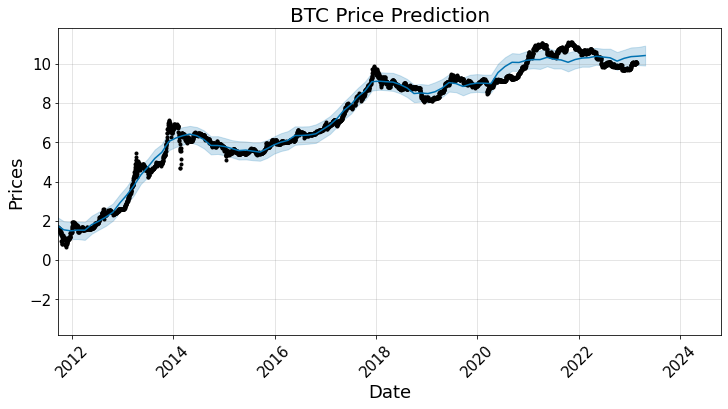

In [22]:
## Combine with Prophet
from datetime import timedelta, date
from prophet import Prophet
df['priceL'] = np.log(df['price'])

df_train = df[['date', 'priceL']]
df_train = df_train.rename(columns = {"date":"ds", "priceL":"y"})

# instantiate the model and set parameters
model = Prophet()

# fit the model to historical data
model.fit(df_train);

start = "2010-09-25"
end = date.today() + timedelta(days=60)
insample = pd.DataFrame(pd.date_range(start,end, periods=92))

# Change the column name
insample.columns = ['ds']

# in-sample prediction
prediction = model.predict(insample)

# Plot
fig = model.plot(prediction, figsize=(10,5))
ax = fig.gca()
ax.set_title("BTC Price Prediction", size=20)
ax.set_xlabel("Date", size=18)
ax.set_ylabel("Prices", size=18)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', rotation=45, labelsize=15)
ax.set_xlim(pd.to_datetime(['2011-09-25', '2024-10-24'])) 
plt.show();

In [23]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="price", color="Valuation", color_discrete_sequence=["red","green","blue","orange"],
                 title="price")
fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))
fig.add_trace(go.Scatter(x=prediction['ds'], y=np.exp(prediction['yhat']),
    fill=None,
    mode='lines',
    line_color='lightblue',
    ))
fig.add_trace(go.Scatter(
    x=prediction['ds'],
    y=np.exp(prediction['yhat_lower']),
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='lightblue'))

fig.add_trace(go.Scatter(
    x=prediction['ds'],
    y=np.exp(prediction['yhat_upper']),
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='lightblue'))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Prophet Model + Buy Zones')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=12)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)
fig.update_layout(showlegend=False)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")
fig.layout.template = 'seaborn'	
fig.show()
fig.write_html('../static/combo.html')

In [24]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.bar(df, x="date", y="price", color="Valuation", color_discrete_sequence=["red","green","blue","orange"],
                 title="price")
fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Buy Zones 2.0')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=12)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)
fig.update_layout(showlegend=True)
fig.update_traces(dict(marker_line_width=.01))
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")	
fig.layout.template = 'seaborn'
fig.show()
fig.write_html('../static/buyzones2.html')

In [25]:
from datetime import date
from datetime import datetime

d1 = str(int(df.price[df['date']=='2014-01-06'].tolist()[0]/df.price[df['date']=='2011-11-25'].tolist()[0]*100)) +"%"
d2 = str(int(-100*(1-(df.price[df['date']=='2015-10-05'].tolist()[0]/df.price[df['date']=='2014-01-07'].tolist()[0])))) + "%"
d3 = str(int(df.price[df['date']=='2018-01-06'].tolist()[0]/df.price[df['date']=='2015-10-06'].tolist()[0]*100)) +"%"
d4 = str(int(-100*(1-(df.price[df['date']=='2019-03-30'].tolist()[0]/df.price[df['date']=='2018-01-07'].tolist()[0])))) + "%"
d5 = str(int(df.price[df['date']=='2021-11-08'].tolist()[0] / df.price[df['date']=='2019-04-01'].tolist()[0] *100)) + "%"
d6 = str(int(-100*(1-(df.price[df['date']== df.date.iloc[-1]].tolist()[0]/df.price[df['date']=='2021-11-09'].tolist()[0])))) + "%"
d7 = str(int(-100*(1-(df.price[df['date']== df.date.iloc[-1]].tolist()[0]/df.price[df['date']=='2023-01-14'].tolist()[0])))) + "%"

import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="price", color="Valuation", color_discrete_sequence=["red","green","blue","orange"],
                 title="price")
fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))
fig.add_trace(go.Scatter(x=prediction['ds'], y=np.exp(prediction['yhat']),
    fill=None,
    mode='lines',
    line_color='lightblue',
    ))
fig.add_trace(go.Scatter(
    x=prediction['ds'],
    y=np.exp(prediction['yhat_lower']),
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='lightblue'))

fig.add_trace(go.Scatter(
    x=prediction['ds'],
    y=np.exp(prediction['yhat_upper']),
    fill='tonexty', # fill area between trace0 and trace1
    mode='lines', line_color='lightblue'))

fig.add_vrect(x0="2011-11-25", x1="2014-01-06", 
              annotation_text=str((date(2014, 2, 4)-date(2011, 11, 25)).days) + " days " + str(d1), annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2014-01-07", x1="2015-10-05", 
              annotation_text=str((date(2015, 10, 7)-date(2014, 2, 5)).days) + " days " + str(d2), annotation_position="top left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="red", opacity=0.25, line_width=0)
fig.add_vrect(x0="2015-10-06", x1="2018-01-06", 
              annotation_text=str((date(2018, 1, 18)-date(2015, 10, 6)).days) +" days " + str(d3), annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2018-01-07", x1="2019-03-30", 
              annotation_text=str((date(2019, 3, 30)-date(2018, 1, 18)).days) + " days " + str(d4), annotation_position="top left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="red", opacity=0.25, line_width=0)
fig.add_vrect(x0="2019-04-01", x1="2021-11-08", 
              annotation_text=str((date(2021, 11, 8)-date(2019, 4, 1)).days) + " days " + str(d5), annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2021-11-09", x1=("2023-01-14"), 
              annotation_text=str((date.today() -date(2021, 11, 8)).days) + " days " + str(d6), annotation_position="top left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="red", opacity=0.25, line_width=0)
fig.add_vrect(x0="2023-01-14", x1=(f'{datetime.today():%Y-%m-%d}'), 
              annotation_text=str((date.today() -date(2023, 1, 14)).days) + " days " + str(d7), annotation_position="left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0=(f'{datetime.today():%Y-%m-%d}'), x1="2024-04-02", 
              annotation_text=str((date(2024, 4, 2)-date.today()).days) + " days halving", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)

fig.add_trace(go.Scatter(
    x=[(date(2021, 11, 8)),(date(2021, 11, 8) +timedelta(days=1079))],
    y=[df.price[df['price']==df.price.max()].tolist()[0],df.price[df['price']==df.price.max()].tolist()[0]],
    mode="markers+text+lines",
    name="Lines and Text",
    text=[ " ",str(df.price[df['price']==df.price.max()].tolist()[0]) + " " + str((date(2021, 11, 8) +timedelta(days=1079)))],
    textposition="bottom center"
))

fig.update_layout(showlegend=False)
fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Prophet Model + Buy Zones + Bull/Bear')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=12)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=15, t=70, b=20),
)
fig.add_vline(x='2012-11-28', line_width=1, line_dash="dash", line_color="black")
fig.add_vline(x='2016-07-09', line_width=1, line_dash="dash", line_color="black")	
fig.add_vline(x='2020-05-11', line_width=1, line_dash="dash", line_color="black")	
fig.add_vline(x='2024-04-02', line_width=1, line_dash="dash", line_color="black")	
fig.layout.template = 'seaborn'
fig.show()
fig.write_html('../static/combodates.html')

In [26]:
df['status'] = df['status'].replace({'0': 'Under'})
df['status'] = df['status'].replace({'1': 'Over'})

In [27]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="price", color="status", color_discrete_sequence=["red", "orange"], trendline="expanding", trendline_options=dict(function="max"), 
                 title="price")

fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Expanding Mean + Time To Reach Previous ATH')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=15)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)

fig.add_vrect(x0="2017-03-17", x1="2013-11-29", 
              annotation_text=str((date(2017, 3, 17)-date(2013, 11, 29)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2017-12-17", x1="2020-11-30", 
              annotation_text=str((date(2020, 11, 30)-date(2017, 12, 17)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2021-11-08", x1=(f'{datetime.today():%Y-%m-%d}'), 
              annotation_text=str((date.today()-date(2021, 11, 8)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0=(f'{datetime.today():%Y-%m-%d}'), x1="2024-04-02", 
              annotation_text=str((date(2024, 4, 2)-date.today()).days) + " days halving", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="red", opacity=0.25, line_width=0)

fig.add_trace(go.Scatter(
    x=[(date(2021, 11, 8)),(date(2021, 11, 8) +timedelta(days=1079))],
    y=[df.price[df['price']==df.price.max()].tolist()[0],df.price[df['price']==df.price.max()].tolist()[0]],
    mode="markers+text+lines",
    name="Lines and Text",
    text=[ " ",str(df.price[df['price']==df.price.max()].tolist()[0]) + " " + str((date(2021, 11, 8) +timedelta(days=1079)))],
    textposition="bottom center"
))

fig.update_layout(showlegend=False)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")	
fig.layout.template = 'seaborn'
fig.show()
fig.write_html('../static/Bitcoinvaluestatus.html')

In [28]:
## Approximate date/time to reach previous ATH

import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="price", color="status", color_discrete_sequence=["red", "orange"], trendline="expanding", trendline_options=dict(function="max"), 
                 title="price")

fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))
# fig.add_trace(go.Scatter(name="Middle Bound", x=prediction['ds'],  mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat']), legendrank=2))
# fig.add_trace(go.Scatter(name="Lower Bound", x=prediction['ds'],  mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat_lower']), legendrank=1))
# fig.add_trace(go.Scatter(name="Upper Bound", x=prediction['ds'], mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat_upper']), legendrank=1))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Cycle Tops')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=15)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)

fig.add_vrect(x0="2017-03-17", x1="2013-11-29", 
              annotation_text=str((date(2017, 3, 17)-date(2013, 11, 29)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2017-12-17", x1="2020-11-30", 
              annotation_text=str((date(2020, 11, 30)-date(2017, 12, 17)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2021-11-08", x1=(f'{datetime.today():%Y-%m-%d}'), 
              annotation_text=str((date.today()-date(2021, 11, 8)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0=(f'{datetime.today():%Y-%m-%d}'), x1="2024-10-22", 
              annotation_text=str((date(2024, 10, 22) - date.today()).days) + " days previous ATH", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="blue", opacity=0.25, line_width=0)

fig.add_trace(go.Scatter(
    x=[(date(2021, 11, 8)),(date(2021, 11, 8) +timedelta(days=1079))],
    y=[df.price[df['price']==df.price.max()].tolist()[0],df.price[df['price']==df.price.max()].tolist()[0]],
    mode="markers+text+lines",
    name="Lines and Text",
    text=[ " ",str(df.price[df['price']==df.price.max()].tolist()[0]) + " " + str((date(2021, 11, 8) +timedelta(days=1079)))],
    textposition="bottom center"
))


fig.update_layout(showlegend=False)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")	
fig.layout.template = 'seaborn'
fig.show()
fig.write_html('../static/approximatenextath.html')

In [29]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="price", color="status", color_discrete_sequence=["red", "orange"], trendline="expanding", trendline_options=dict(function="max"), 
                 title="price")

fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Expanding Mean + Meanaverage')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=15)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)

fig.add_vrect(x0="2011-09-04", x1="2012-05-16", 
              annotation_text=str((date(2012, 5, 16)-date(2011, 9, 4)).days) + " days", annotation_position="top left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2012-05-17", x1="2014-02-10", 
              annotation_text=str((date(2014, 2, 10)-date(2012, 5, 17)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2014-02-11", x1="2015-10-06", 
              annotation_text=str((date(2015, 10, 6)-date(2014, 2, 11)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2015-10-07", x1="2018-02-18", 
              annotation_text=str((date(2018, 2, 18)-date(2015, 10, 7)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2018-02-19", x1="2019-04-02", 
              annotation_text=str((date(2019, 4, 2)-date(2018, 2, 19)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2019-04-03", x1="2021-11-07", 
              annotation_text=str((date(2021, 11, 7)-date(2019, 4, 3)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2021-11-08", x1=("2023-01-14"), 
              annotation_text=str((date.today()-date(2021, 11, 8)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2023-01-14", x1=(f'{datetime.today():%Y-%m-%d}'), 
              annotation_text=str((date.today()-date(2023, 1, 14)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
# fig.add_vrect(x0=(f'{datetime.today():%Y-%m-%d}'), x1="2024-04-02", 
#               annotation_text=str((date(2024, 4, 2)-date.today()).days) + " days halving", annotation_position="bottom left",
#               annotation=dict(font_size=15, font_family="Times New Roman"),
#               fillcolor="red", opacity=0.25, line_width=0)

fig.add_trace(go.Scatter(
    x=[(date(2021, 11, 8)),(date(2021, 11, 8) +timedelta(days=1079))],
    y=[df.price[df['price']==df.price.max()].tolist()[0],df.price[df['price']==df.price.max()].tolist()[0]],
    mode="markers+text+lines",
    name="Lines and Text",
    text=[ " ",str(df.price[df['price']==df.price.max()].tolist()[0]) + " " + str((date(2021, 11, 8) +timedelta(days=1079)))],
    textposition="top center"
))
        

fig.update_layout(showlegend=False)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")	
fig.layout.template = 'seaborn'
fig.show()
fig.write_html('../static/Bitcoinvaluestatus2.html')

In [30]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.bar(df, x="date", y="price", color="status", color_discrete_sequence=["red", "orange"], 
                 title="price")

fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Under vs Over')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=15)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)

fig.update_traces(dict(marker_line_width=.01))


fig.update_layout(showlegend=False)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")	
fig.layout.template = 'seaborn'
fig.show()
fig.write_html('../static/overunder.html')

In [31]:
df['rateofchangemove%'] = df['move%'].diff()


In [32]:
df_tail=df.dropna()
df_tail = df_tail.tail(90)
df_tail.head()

date         price        Volume      meanavge    meanvalue status  \
4417 2022-11-26  16464.281250  1.800001e+10  22922.593855 -6458.312605  Under   
4418 2022-11-27  16444.626953  2.044390e+10  22857.247665 -6412.620712  Under   
4419 2022-11-28  16217.322266  2.774303e+10  22789.500487 -6572.178221  Under   
4420 2022-11-29  16444.982422  2.358169e+10  22727.453765 -6282.471343  Under   
4421 2022-11-30  17168.566406  2.952358e+10  22670.975781 -5502.409375  Under   

      price-meanavge      move%         Valuation        macd      macd_h  \
4417    -6458.312605 -16.397119  Neutral Oversold -746.068359   63.409213   
4418    -6412.620712 -16.316323  Neutral Oversold -709.335602   80.113576   
4419    -6572.178221 -16.848791  Neutral Oversold -690.605348   79.075065   
4420    -6282.471343 -16.037990  Neutral Oversold -649.899577   95.824669   
4421    -5502.409375 -13.811427  Neutral Oversold -552.879528  154.275774   

          macd_s    priceL  rateofchangemove%  
4417 -809.477573  9.708949          -0.024579  
4418 -789.449178  9.707754           0.080796  
4419 -769.680412  9.693835          -0.532469  
4420 -745.724245  9.707776           0.810802  
4421 -707.155302  9.750835           2.226563

In [33]:
import pandas_ta as pta
df_tail['RSI'] = pta.rsi(df_tail['price'], length = 14)

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=4, cols=1,shared_xaxes=True,vertical_spacing=0.01, row_heights=[0.2, 0.04,0.04,0.04])

fig.add_trace(
    go.Scatter(name="Price",x=df_tail['date'], y=df_tail['price'],
        marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=1, col=1)


fig.add_trace(
    go.Bar(name="macd",x=df_tail['date'], y=df_tail['macd'],
    marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_s",x=df_tail['date'], y=df_tail['macd_s'],
    marker=dict(color=df_tail['macd_s'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_h",x=df_tail['date'], y=df_tail['macd_h'],
    marker=dict(color=df_tail['macd_h'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(go.Bar(x=df_tail['date'], y=df_tail['move%'],
                    marker=dict(color=df_tail['move%'], coloraxis="coloraxis2")),
              3, 1)

fig.add_trace(
    go.Scatter(name="RSI",x=df_tail['date'], y=df_tail['RSI'],
    marker=dict(color=df_tail['RSI'], coloraxis="coloraxis3")),
    row=4, col=1)

fig.update_yaxes(nticks=10)
fig.update_xaxes(nticks=50)
fig.update_layout(coloraxis1=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis2=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis3=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis1_showscale=False)
fig.update_layout(coloraxis2_showscale=False)
fig.update_layout(height=900, width=1000, title_text="90 Day MACD, RSI, Price and Move%")
fig.update_layout(template='plotly_dark')
fig.show()
fig.write_html('../static/macd&move.html')

In [ ]:
import pandas_ta as pta
df_tail['RSI'] = pta.rsi(df_tail['price'], length = 14)

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=4, cols=1,shared_xaxes=True,vertical_spacing=0.01, row_heights=[0.2, 0.04,0.04,0.04])

fig.add_trace(
    go.Scatter(name="Price",x=df_tail['date'], y=df_tail['price'],
        marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=1, col=1)


fig.add_trace(
    go.Bar(name="macd",x=df_tail['date'], y=df_tail['macd'],
    marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_s",x=df_tail['date'], y=df_tail['macd_s'],
    marker=dict(color=df_tail['macd_s'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_h",x=df_tail['date'], y=df_tail['macd_h'],
    marker=dict(color=df_tail['macd_h'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(go.Bar(x=df_tail['date'], y=df_tail['move%'],
                    marker=dict(color=df_tail['move%'], coloraxis="coloraxis2")),
              3, 1)

fig.add_trace(
    go.Scatter(name="RSI",x=df_tail['date'], y=df_tail['RSI'],
    marker=dict(color=df_tail['RSI'], coloraxis="coloraxis3")),
    row=4, col=1)

fig.update_yaxes(nticks=10)
fig.update_xaxes(nticks=50)
fig.update_layout(coloraxis1=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis2=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis3=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis1_showscale=False)
fig.update_layout(coloraxis2_showscale=False)
fig.update_layout(height=900, width=1000, title_text="90 Day MACD, RSI, Price and Move%")
fig.update_layout(template='plotly_dark')
fig.show()
fig.write_html('../static/macd&move.html')

In [ ]:
import pandas_ta as pta
df_tail['RSI'] = pta.rsi(df_tail['price'], length = 14)

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=4, cols=1,shared_xaxes=True,vertical_spacing=0.01, row_heights=[0.2, 0.04,0.04,0.04])

fig.add_trace(
    go.Scatter(name="Price",x=df_tail['date'], y=df_tail['price'],
        marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=1, col=1)


fig.add_trace(
    go.Bar(name="macd",x=df_tail['date'], y=df_tail['macd'],
    marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_s",x=df_tail['date'], y=df_tail['macd_s'],
    marker=dict(color=df_tail['macd_s'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_h",x=df_tail['date'], y=df_tail['macd_h'],
    marker=dict(color=df_tail['macd_h'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(go.Bar(x=df_tail['date'], y=df_tail['move%'],
                    marker=dict(color=df_tail['move%'], coloraxis="coloraxis2")),
              3, 1)

fig.add_trace(
    go.Scatter(name="RSI",x=df_tail['date'], y=df_tail['RSI'],
    marker=dict(color=df_tail['RSI'], coloraxis="coloraxis3")),
    row=4, col=1)

fig.update_yaxes(nticks=10)
fig.update_xaxes(nticks=50)
fig.update_layout(coloraxis1=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis2=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis3=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis1_showscale=False)
fig.update_layout(coloraxis2_showscale=False)
fig.update_layout(height=900, width=1000, title_text="90 Day MACD, RSI, Price and Move%")
fig.update_layout(template='plotly_dark')
fig.show()
fig.write_html('../static/macd&move.html')

In [ ]:
import pandas_ta as pta
df_tail['RSI'] = pta.rsi(df_tail['price'], length = 14)

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=4, cols=1,shared_xaxes=True,vertical_spacing=0.01, row_heights=[0.2, 0.04,0.04,0.04])

fig.add_trace(
    go.Scatter(name="Price",x=df_tail['date'], y=df_tail['price'],
        marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=1, col=1)


fig.add_trace(
    go.Bar(name="macd",x=df_tail['date'], y=df_tail['macd'],
    marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_s",x=df_tail['date'], y=df_tail['macd_s'],
    marker=dict(color=df_tail['macd_s'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_h",x=df_tail['date'], y=df_tail['macd_h'],
    marker=dict(color=df_tail['macd_h'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(go.Bar(x=df_tail['date'], y=df_tail['move%'],
                    marker=dict(color=df_tail['move%'], coloraxis="coloraxis2")),
              3, 1)

fig.add_trace(
    go.Scatter(name="RSI",x=df_tail['date'], y=df_tail['RSI'],
    marker=dict(color=df_tail['RSI'], coloraxis="coloraxis3")),
    row=4, col=1)

fig.update_yaxes(nticks=10)
fig.update_xaxes(nticks=50)
fig.update_layout(coloraxis1=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis2=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis3=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis1_showscale=False)
fig.update_layout(coloraxis2_showscale=False)
fig.update_layout(height=900, width=1000, title_text="90 Day MACD, RSI, Price and Move%")
fig.update_layout(template='plotly_dark')
fig.show()
fig.write_html('../static/macd&move.html')

In [ ]:
import pandas_ta as pta
df_tail['RSI'] = pta.rsi(df_tail['price'], length = 14)

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=4, cols=1,shared_xaxes=True,vertical_spacing=0.01, row_heights=[0.2, 0.04,0.04,0.04])

fig.add_trace(
    go.Scatter(name="Price",x=df_tail['date'], y=df_tail['price'],
        marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=1, col=1)


fig.add_trace(
    go.Bar(name="macd",x=df_tail['date'], y=df_tail['macd'],
    marker=dict(color=df_tail['macd'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_s",x=df_tail['date'], y=df_tail['macd_s'],
    marker=dict(color=df_tail['macd_s'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(
    go.Scatter(name="macd_h",x=df_tail['date'], y=df_tail['macd_h'],
    marker=dict(color=df_tail['macd_h'], coloraxis="coloraxis1")),
    row=2, col=1)

fig.add_trace(go.Bar(x=df_tail['date'], y=df_tail['move%'],
                    marker=dict(color=df_tail['move%'], coloraxis="coloraxis2")),
              3, 1)

fig.add_trace(
    go.Scatter(name="RSI",x=df_tail['date'], y=df_tail['RSI'],
    marker=dict(color=df_tail['RSI'], coloraxis="coloraxis3")),
    row=4, col=1)

fig.update_yaxes(nticks=10)
fig.update_xaxes(nticks=50)
fig.update_layout(coloraxis1=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis2=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis3=dict(colorscale='Bluered_r'), showlegend=True)
fig.update_layout(coloraxis1_showscale=False)
fig.update_layout(coloraxis2_showscale=False)
fig.update_layout(height=900, width=1000, title_text="90 Day MACD, RSI, Price and Move%")
fig.update_layout(template='plotly_dark')
fig.show()
fig.write_html('../static/macd&move.html')

In [34]:
btccandle = yf.download('BTC-USD')
btccandle = btccandle.reset_index()
btccandle

[*********************100%***********************]  1 of 1 completed


Date          Open          High           Low         Close  \
0    2014-09-17    465.864014    468.174011    452.421997    457.334015   
1    2014-09-18    456.859985    456.859985    413.104004    424.440002   
2    2014-09-19    424.102997    427.834991    384.532013    394.795990   
3    2014-09-20    394.673004    423.295990    389.882996    408.903992   
4    2014-09-21    408.084991    412.425995    393.181000    398.821014   
...         ...           ...           ...           ...           ...   
3076 2023-02-18  24565.296875  24798.835938  24468.373047  24641.277344   
3077 2023-02-19  24640.027344  25093.054688  24327.642578  24327.642578   
3078 2023-02-20  24336.623047  25020.458984  23927.910156  24829.148438   
3079 2023-02-21  24833.048828  25126.851562  24200.363281  24436.353516   
3080 2023-02-22  24437.417969  24472.339844  23644.318359  24188.843750   

         Adj Close       Volume  
0       457.334015     21056800  
1       424.440002     34483200  
2       394.795990     37919700  
3       408.903992     36863600  
4       398.821014     26580100  
...            ...          ...  
3076  24641.277344  19625427158  
3077  24327.642578  25555105670  
3078  24829.148438  28987376573  
3079  24436.353516  31252098714  
3080  24188.843750  30199996781  

[3081 rows x 7 columns]

In [35]:
df = yf.Ticker('BTC-USD').history(period='7y',interval='1d',actions=False)
df

Open          High           Low         Close  \
Date                                                                 
2016-02-25    425.036987    427.718994    420.415009    424.544006   
2016-02-26    424.628998    432.152008    421.619995    432.152008   
2016-02-27    432.838989    434.230988    428.102997    432.519012   
2016-02-28    432.571014    435.683014    423.820007    433.503998   
2016-02-29    433.437988    441.506989    431.692993    437.696991   
...                  ...           ...           ...           ...   
2023-02-19  24640.027344  25093.054688  24327.642578  24327.642578   
2023-02-20  24336.623047  25020.458984  23927.910156  24829.148438   
2023-02-21  24833.048828  25126.851562  24200.363281  24436.353516   
2023-02-22  24437.417969  24472.339844  23644.318359  24188.843750   
2023-02-25  23195.015625  23201.943359  22906.292969  23009.216797   

                 Volume  
Date                     
2016-02-25     70798000  
2016-02-26     61486000  
2016-02-27     41893600  
2016-02-28     53033400  
2016-02-29     60694700  
...                 ...  
2023-02-19  25555105670  
2023-02-20  28987376573  
2023-02-21  31252098714  
2023-02-22  30199996781  
2023-02-25  17264943104  

[2556 rows x 5 columns]